## Problem Statement

#### Farmers often struggle to decide which crop to plant for maximum yield based on soil and weather conditions.A wrong choice of crop can lead to low productivity, financial loss, and wastage of natural resources.Using historical agricultural data like soil nutrients (N, P, K), temperature, humidity, pH level, and rainfall, we can predict the most suitable crop.The goal is to build a machine learning model that accurately recommends the best crop based on the given environmental conditions.This system aims to help farmers make data-driven decisions, improving agricultural productivity and sustainability.

### Importing Libraries

In [3]:

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [5]:
df = pd.read_csv('Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
df.shape

(2200, 8)

In [7]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

### Data Pre-Processing

In [9]:
df.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

In [10]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [11]:
df["label"].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

In [12]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [13]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


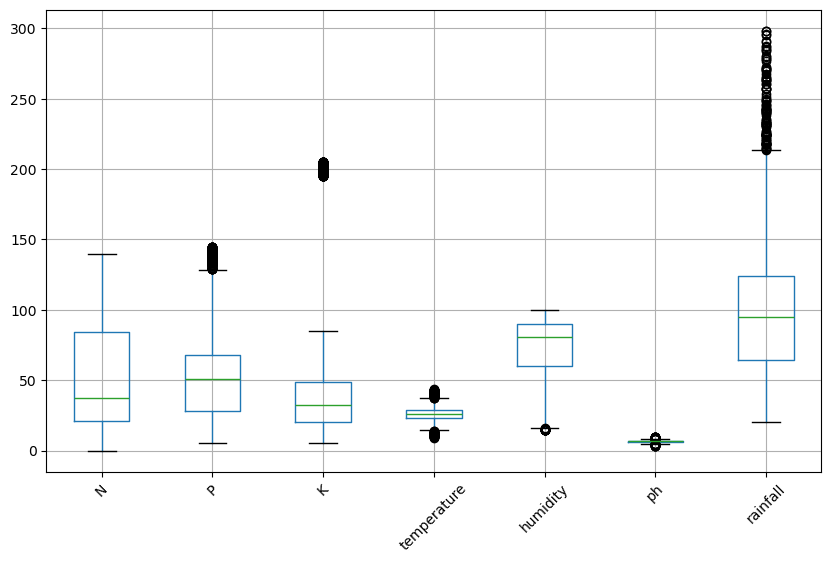

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(10,6))
df[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.show()


In [15]:
# Apply log transformation for skewed features like rainfall
df['rainfall'] = np.log1p(df['rainfall'])  # Log transformation

# Standardize all numeric columns if necessary
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [16]:
df.rename(columns = {'label':'Crop'}, inplace = True)

### Feature Engineering

In [18]:

### NPK Ratio (helps in agriculture datasets)

df['NPK_Ratio'] = df['N'] / (df['P'] + df['K'] + 1)  # +1 to avoid division by zero

### Temperature-Humidity Interaction
df['Temp_Humidity'] = df['temperature'] * df['humidity']

### Rainfall Binning (convert continuous rainfall values into categories)
df['Rainfall_Category'] = pd.cut(df['rainfall'], bins=[0,50,100,200,300], labels=['Low','Moderate','High','Very High'])
df

,N,P,K,temperature,humidity,ph,rainfall,Crop,NPK_Ratio,Temp_Humidity,Rainfall_Category
0,90,42,43,20.879744,82.002744,6.502985,5.317804,rice,1.046512,1712.196283,Low
1,85,58,41,21.770462,80.319644,7.038096,5.427834,rice,0.850000,1748.595734,Low
2,60,55,44,23.004459,82.320763,7.840207,5.579595,rice,0.600000,1893.744627,Low
3,74,35,40,26.491096,80.158363,6.980401,5.496611,rice,0.973684,2123.482908,Low
4,78,42,42,20.130175,81.604873,7.628473,5.574878,rice,0.917647,1642.720357,Low
...,...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,5.186125,coffee,1.597015,1778.191164,Low
2196,99,15,27,27.417112,56.636362,6.086922,4.859228,coffee,2.302326,1552.805515,Low
2197,118,33,30,24.131797,67.225123,6.362608,5.160909,coffee,1.843750,1622.263022,Low
2198,117,32,34,26.272418,52.127394,6.758793,4.853399,coffee,1.746269,1369.512711,Low


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   N                  2200 non-null   int64   
 1   P                  2200 non-null   int64   
 2   K                  2200 non-null   int64   
 3   temperature        2200 non-null   float64 
 4   humidity           2200 non-null   float64 
 5   ph                 2200 non-null   float64 
 6   rainfall           2200 non-null   float64 
 7   Crop               2200 non-null   object  
 8   NPK_Ratio          2200 non-null   float64 
 9   Temp_Humidity      2200 non-null   float64 
 10  Rainfall_Category  2200 non-null   category
dtypes: category(1), float64(6), int64(3), object(1)
memory usage: 174.4+ KB


## Exploratory Data Analysis(EDA)

### Univariate Analysis

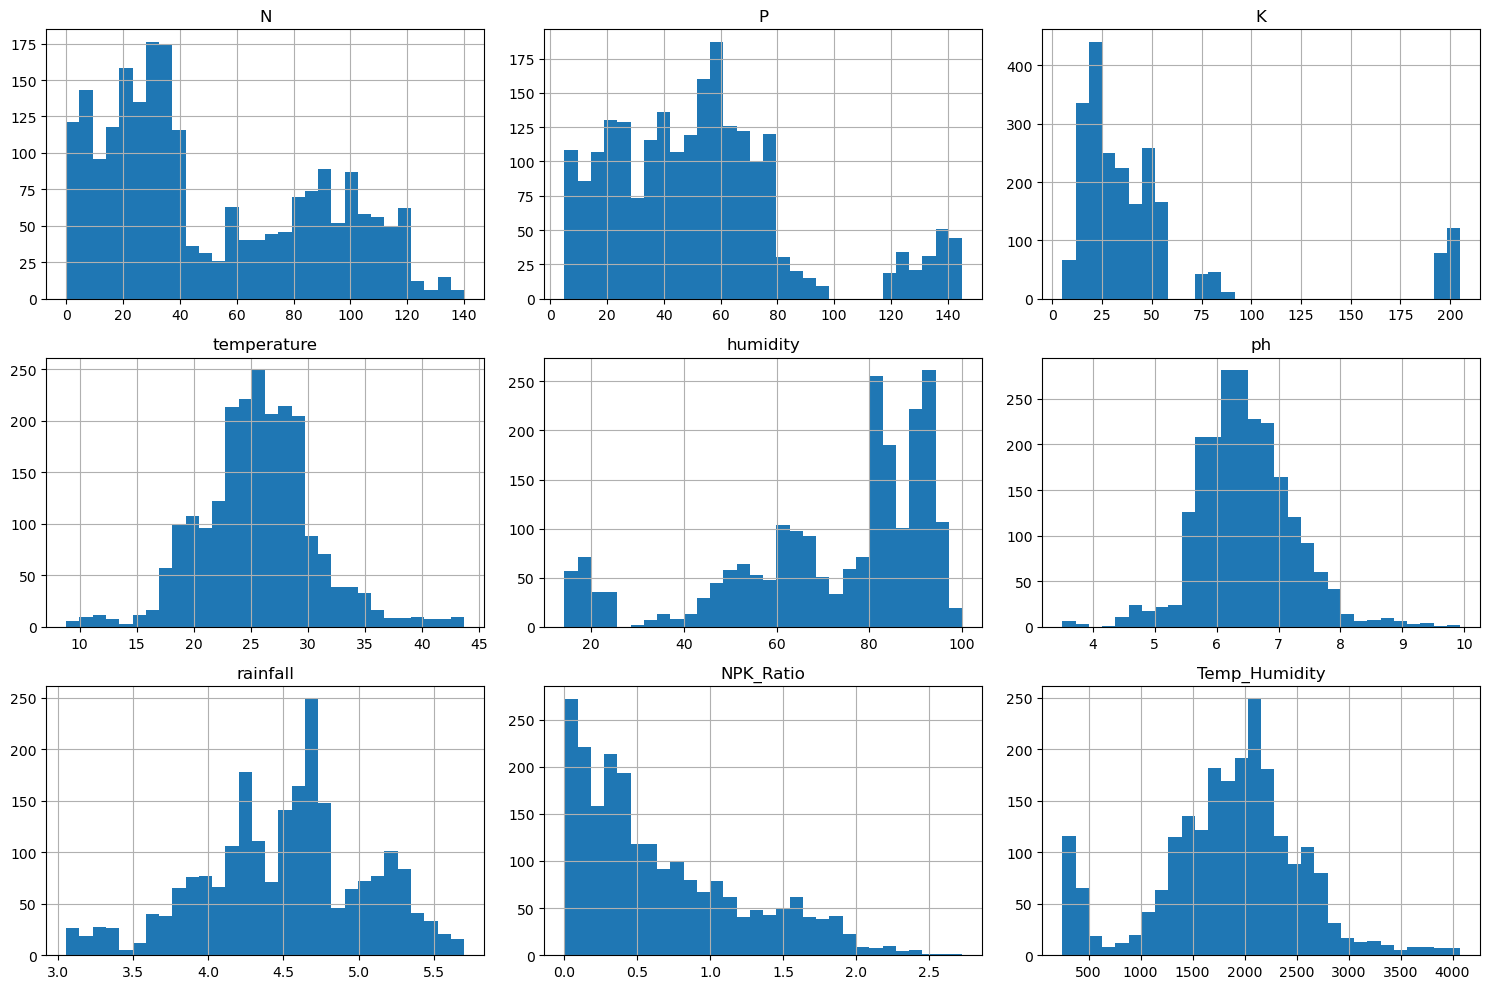

In [21]:
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'NPK_Ratio', 'Temp_Humidity']

df[numerical_features].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


### Bi-Variate Analysis

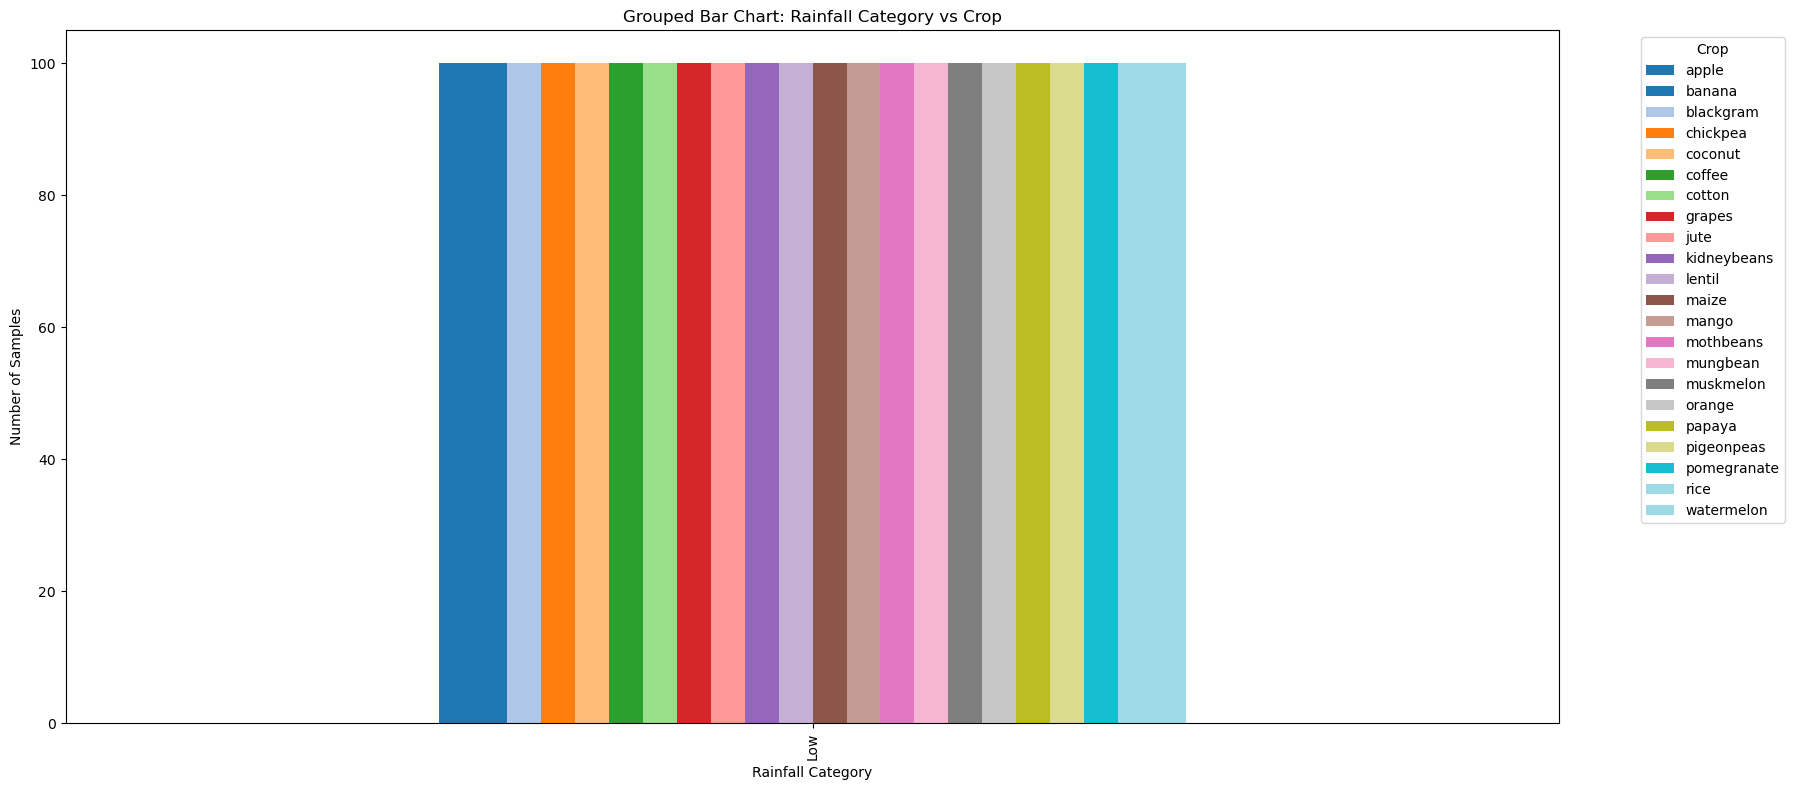

In [23]:
# Prepare the data (Crosstab)
crosstab_data = pd.crosstab(df['Rainfall_Category'], df['Crop'])

# Plot Grouped Bar Chart
crosstab_data.plot(kind='bar', stacked=False, figsize=(18, 8), colormap='tab20')
plt.title('Grouped Bar Chart: Rainfall Category vs Crop')
plt.xlabel('Rainfall Category')
plt.ylabel('Number of Samples')
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


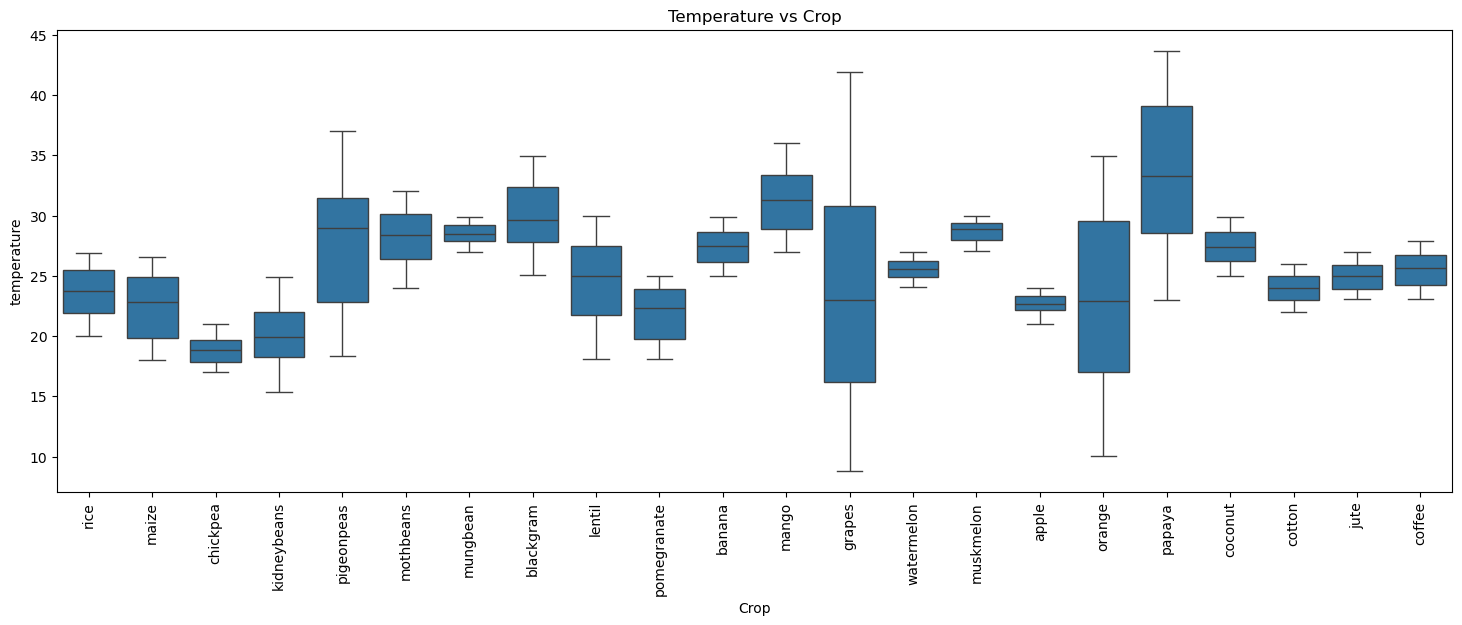

In [24]:
plt.figure(figsize=(18, 6))
sns.boxplot(x='Crop', y='temperature', data=df)
plt.xticks(rotation=90)
plt.title('Temperature vs Crop')
plt.show()


### Multi-Variate Analysis

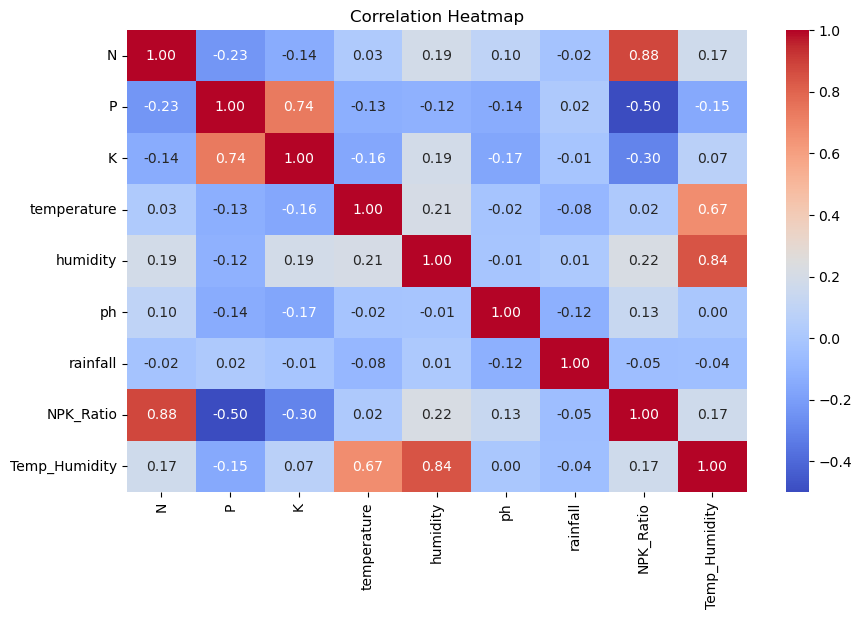

In [26]:
plt.figure(figsize=(10, 6))
corr = df[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


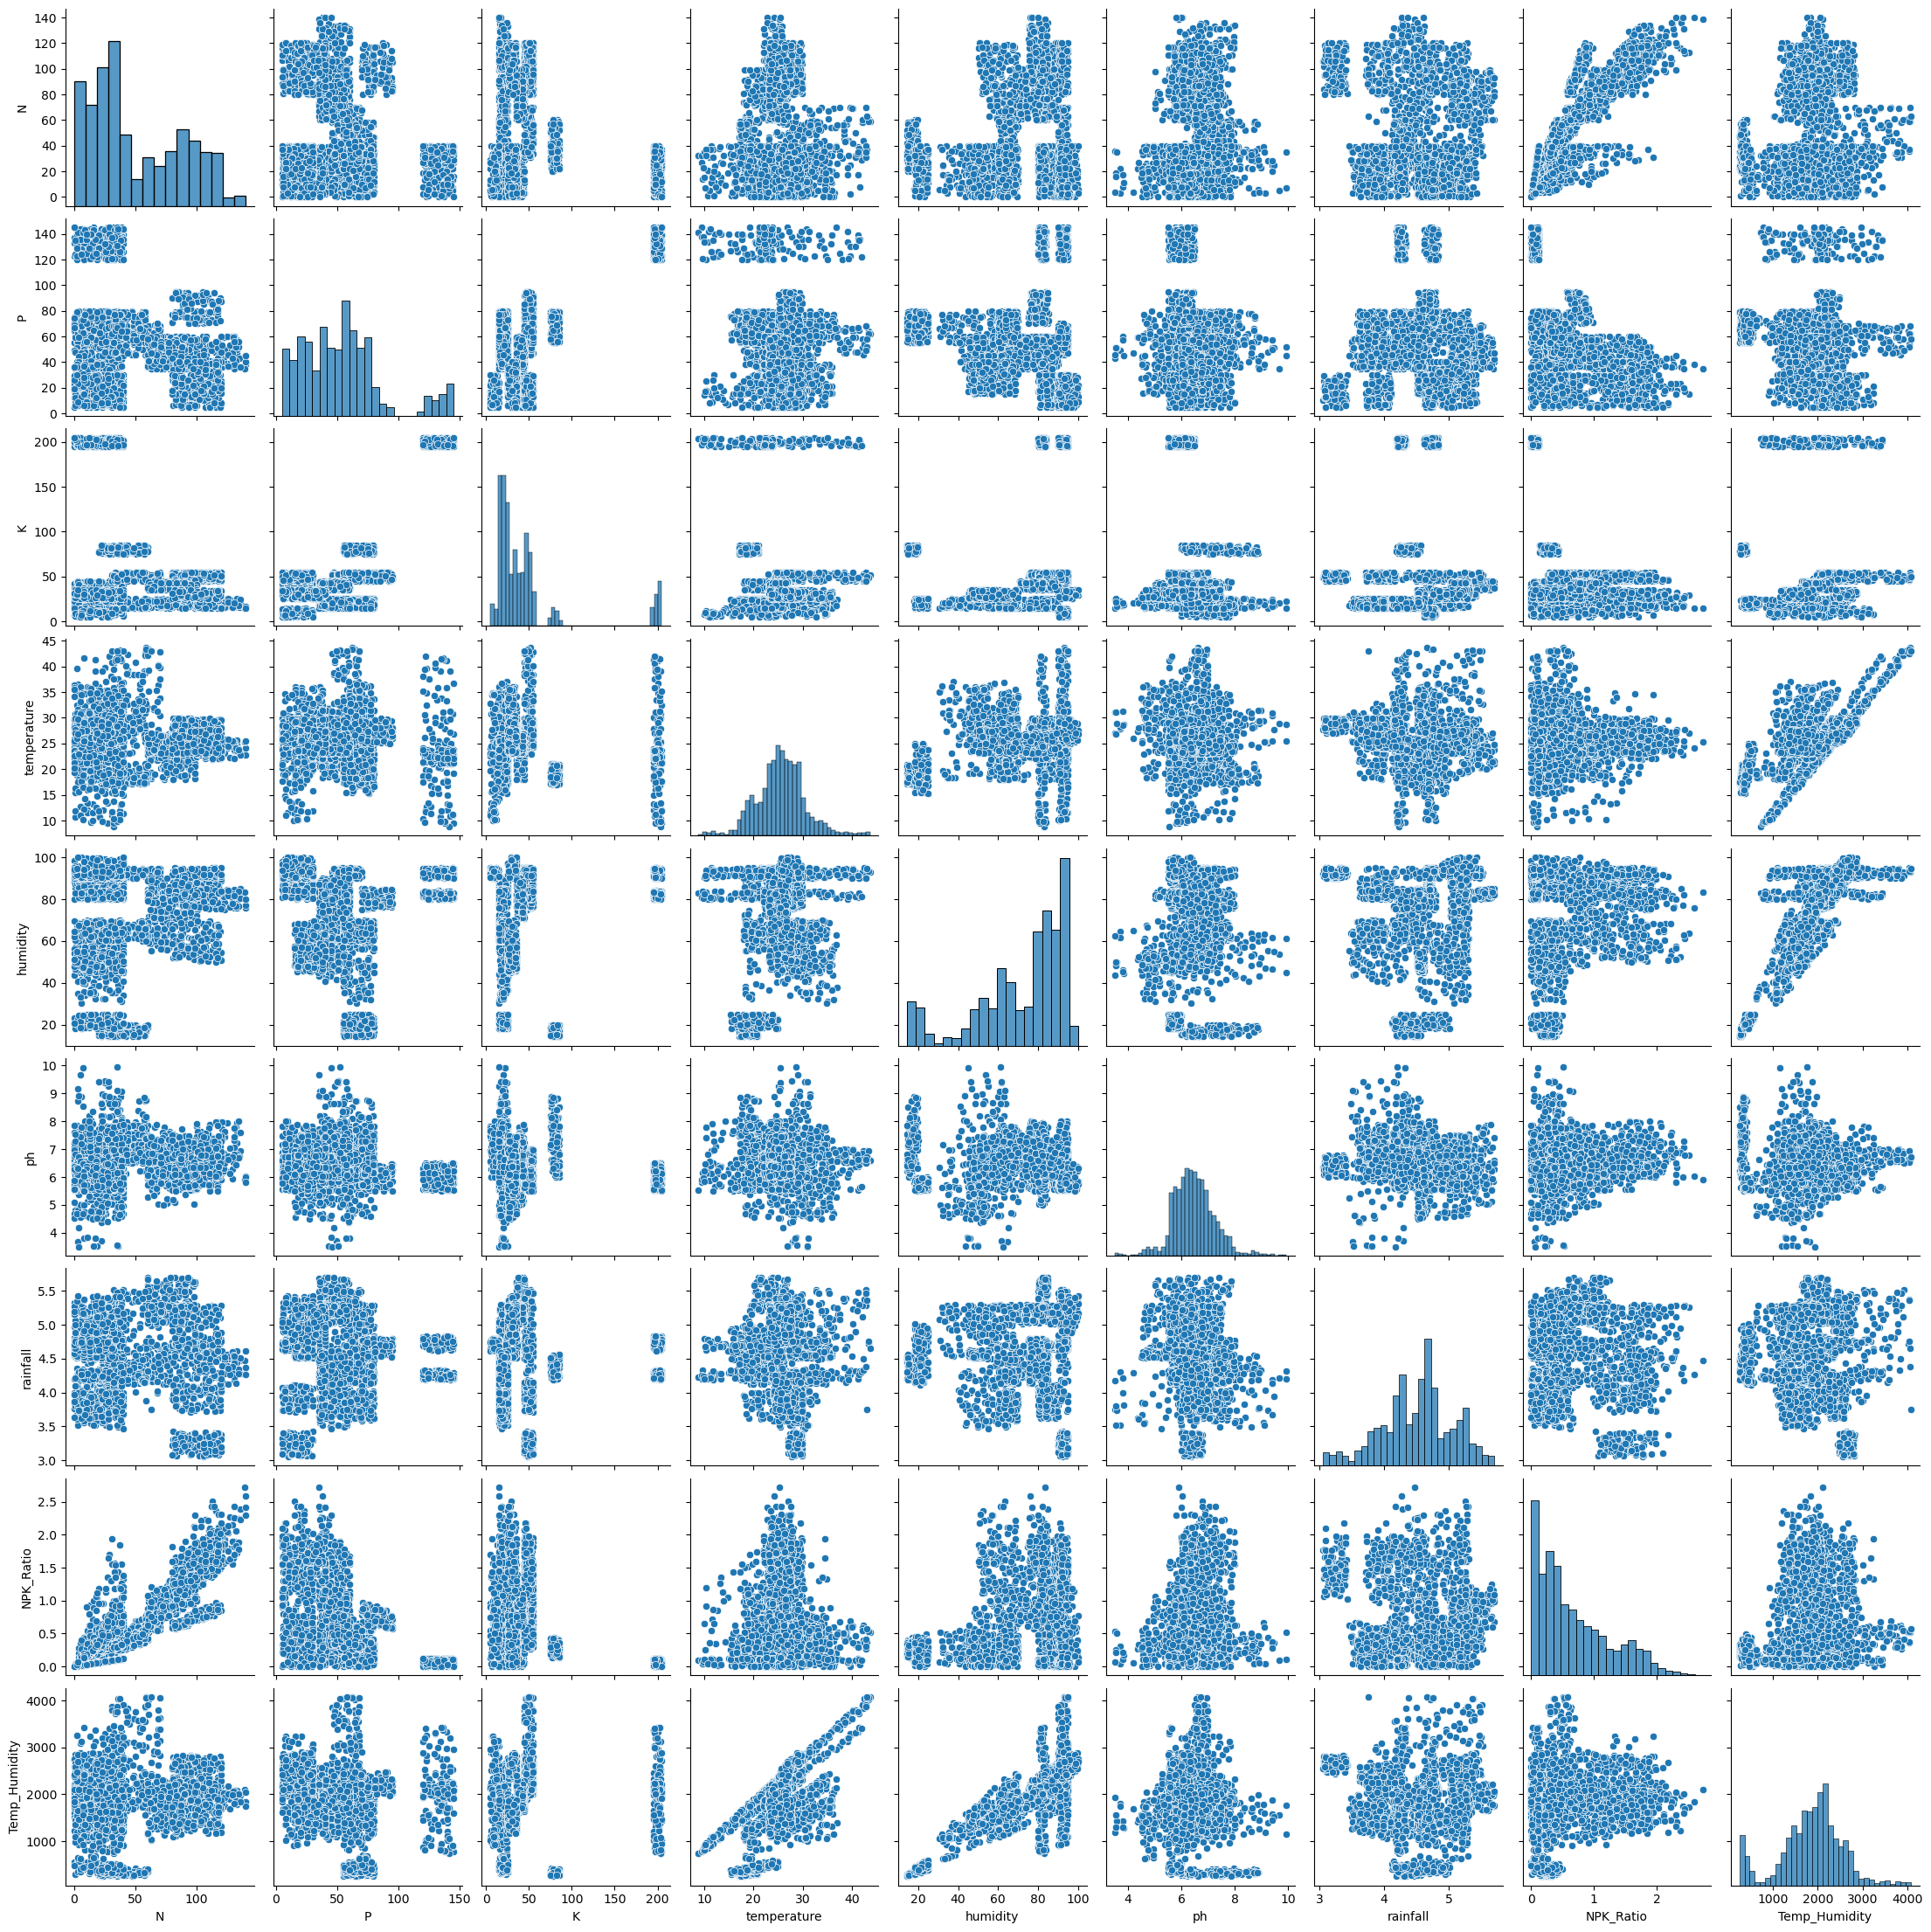

In [27]:

sns.pairplot(df[numerical_features])
plt.show()


### Seperating features and target label

In [29]:
features = df[['N', 'P','K','temperature', 'humidity', 'ph', 'rainfall']]
target = df['Crop']
#features = df[['temperature', 'humidity', 'ph', 'rainfall']]
labels = df['Crop']

In [30]:
# Initialzing empty lists to append all model's name and corresponding name
acc = []
model = []

In [31]:
# Splitting into train and test data

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features,target,test_size = 0.2,random_state =2)

In [32]:
Xtrain.shape

(1760, 7)

## Model Training

## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state=2)

LogReg.fit(Xtrain,Ytrain)

predicted_values = LogReg.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Logistic Regression')
print("Logistic Regression's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Logistic Regression's Accuracy is:  0.8886363636363637
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.59      0.62      0.61        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        18
        jute       0.81      0.46      0.59        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       0.82      0.78      0.80        23
       maize       0.95      0.95      0.95        21
       mango       1.00      0.96      0.98        26
   mothbeans       0.67      0.84      0.74        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       0.83      0.83      0.83        23
      orange       1.00   

In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
# Cross validation score (Logistic Regression)
score = cross_val_score(LogReg,features,target,cv=4)
score

array([0.89090909, 0.89636364, 0.89818182, 0.89454545])

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=20, random_state=0)
RF.fit(Xtrain,Ytrain)

predicted_values = RF.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('RF')
print("RF's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

RF's Accuracy is:  0.990909090909091
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.94      1.00      0.97        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.90      1.00      0.95        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      0.95      0.97        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00 

In [39]:
# Cross validation score (Random Forest)
score = cross_val_score(RF,features,target,cv=5)
score

array([0.99772727, 0.99545455, 0.99772727, 0.99318182, 0.98863636])

## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(Xtrain,Ytrain)

predicted_values = DecisionTree.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Decision Tree')
print("DecisionTrees's Accuracy is: ", x*100)

print(classification_report(Ytest,predicted_values))

DecisionTrees's Accuracy is:  90.0
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.59      1.00      0.74        16
    chickpea       1.00      1.00      1.00        21
     coconut       0.91      1.00      0.95        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.74      0.93      0.83        28
 kidneybeans       0.00      0.00      0.00        14
      lentil       0.68      1.00      0.81        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       0.00      0.00      0.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00   

In [42]:
# Cross validation score (Decision Tree)
score = cross_val_score(DecisionTree, features, target,cv=5)
score

array([0.93636364, 0.90909091, 0.91818182, 0.87045455, 0.93636364])

## Support Vector Machine (SVM)

In [44]:
from sklearn.svm import SVC
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(Xtrain)
X_train_norm = norm.transform(Xtrain)
# transform testing dataabs
X_test_norm = norm.transform(Xtest)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm,Ytrain)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM')
print("SVM's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

SVM's Accuracy is:  0.975
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.94      1.00      0.97        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      0.95      0.98        22
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        18
        jute       0.83      0.86      0.84        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      0.95      0.97        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        29
 

In [45]:
# Cross validation score (SVM)
score = cross_val_score(SVM,features,target,cv=5)
score

array([0.91363636, 0.93863636, 0.93181818, 0.90681818, 0.91590909])

### Accuracy Comparison

<Axes: title={'center': 'Accuracy Comparison'}, xlabel='Accuracy', ylabel='Algorithm'>

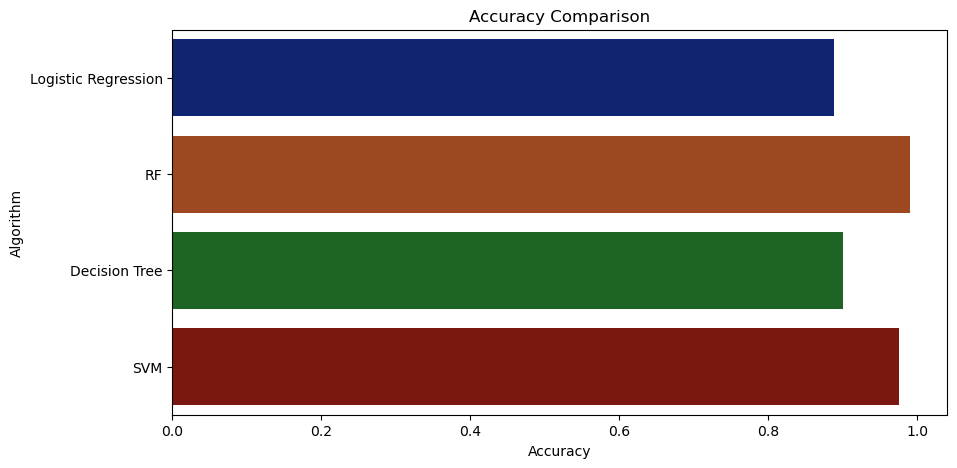

In [47]:
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = model,palette='dark')

In [48]:
accuracy_models = dict(zip(model, acc))
for k, v in accuracy_models.items():
    print (k, '-->', v)

Logistic Regression --> 0.8886363636363637
RF --> 0.990909090909091
Decision Tree --> 0.9
SVM --> 0.975


## Making a prediction

In [50]:
data = np.array([[104,18, 30, 23.603016, 60.3, 6.7, 140.91]])
prediction = RF.predict(data)
print(prediction)

['coffee']


In [51]:
data = np.array([[90, 475, 60, 30, 70.3, 7.0, 150.9]])
prediction = RF.predict(data)
print(prediction)

['banana']


In [88]:
data = np.array([[120, 45, 90, 68, 70.3, 7.0, 150.9]])
prediction = RF.predict(data)
print(prediction)

['chickpea']
